# Lab 2 - Playground
Note: this notebook is completely optional, and only exists to introduce some topics in greater detail than the lab itself. 

## Ngram language modeling and Word Embeddings
Below you will find practical examples of how you can implement a simple next-word predictor, as well as generate embeddings for words. This will include libraries that are not covered until later labs (scikit-learn and gensim), but as this is a playground, you're left to explore it if you wish!

### Ngram language modeling
An example of next-word prediction with NLTK by using a simple n-gram model.

In [1]:
from typing import List, Optional, Tuple
import nltk

class NgramModel:
    def __init__(self, measures, finder, corpus, n_gram) -> None:
        self.model = finder.from_words(corpus).score_ngrams(measures.raw_freq)
        self.n_gram = n_gram
        
    def compare_ngram(self, this: Optional[Tuple[str]], that: Tuple[str]) -> bool:
        """ a function to compare the n-1 words in the nltk collocation model
        Args:
            this (str or list of strings): the user input
            that (list): the existing tuples up to range N-1
        """
        if not this:
            return False

        return list(that[0][:len(this)]) == this
    
    def predict(self, tokens: List[str], n_words: int=4, return_ngram: bool = False) -> List[str]:
        n_tokens = tokens[-(self.n_gram - 1):]
        model_name = "bigram" if self.n_gram == 2 else "trigram"
        print(f"{model_name} tokens: {n_tokens}")
        probas = [w for w in self.model if self.compare_ngram(n_tokens, w)]
        best_probas = sorted(probas, key=lambda x: x[1], reverse=True)
        # best_words = [w[0][-1] for w in best_probas]
        if return_ngram:
            return [w[0] for w in best_probas][:n_words]
        return [w[0][-1] for w in best_probas][:n_words]

In [2]:
class BigramModel(NgramModel):
    def __init__(self, corpus) -> None:
        super().__init__(
            measures=nltk.collocations.BigramAssocMeasures(),
            finder=nltk.collocations.BigramCollocationFinder,
            corpus=corpus,
            n_gram=2
        )

class TrigramModel(NgramModel):
    def __init__(self, corpus) -> None:
        super().__init__(
            measures=nltk.collocations.TrigramAssocMeasures(),
            finder=nltk.collocations.TrigramCollocationFinder,
            corpus=corpus,
            n_gram=3,
        )

In [3]:
from nltk.corpus import brown
corpus = brown.words()
corpus = [w.lower() for w in corpus if w.isalpha()]
model = TrigramModel(corpus)

In [4]:
from nltk.tokenize import word_tokenize

def predict(model, text):
    tokens = word_tokenize(text)
    output = model.predict(tokens)
    return output

predict(model, "have you")

trigram tokens: ['have', 'you']


['ever', 'got', 'considered', 'any']

# Word vectors
The example below uses Gensim (a library not used for a few labs, but this is a playground, after all) to generate embeddings with Word2Vec.

In [ ]:
%pip install gensim scikit-learn matplotlib

In [6]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

# Dummy data
false_corpus = [
    "Computer science students enjoy nothing but coding",
    "Students love reading books",
    "Students like books",
    "Students hate beer",
    "Homework is the best gift for students",
    "Students can't wait to do the project in the NLP course",
]
tokenized = [word_tokenize(sent.lower()) for sent in false_corpus]


def one_hot_encoding(word, vocab):
    vector = [0] * len(vocab)
    vector[vocab.index(word)] = 1
    return vector


vocab = list(set(word for sent in tokenized for word in sent))
print(vocab)

['nlp', 'love', 'gift', 'enjoy', 'students', "n't", 'nothing', 'do', 'science', 'wait', 'best', 'to', 'course', 'homework', 'project', 'hate', 'is', 'the', 'in', 'like', 'books', 'coding', 'computer', 'for', 'reading', 'beer', 'ca', 'but']


In [7]:
import random

# One-hot encoding
one_hotted = [one_hot_encoding(word, vocab) for sent in tokenized for word in sent]

# Word2Vec
word2vec_model = Word2Vec(sentences=tokenized, vector_size=10, window=3, min_count=1)

print("Example word embeddings:")
for word in random.sample(vocab, 5):
    print(f"{word}: {word2vec_model.wv[word]}")

Example word embeddings:
nothing: [ 0.05457946  0.08343768 -0.01454489 -0.09209523  0.04368281  0.00573161
  0.07444196 -0.0081222  -0.0264008  -0.08752415]
students: [-0.00532198  0.00233778  0.0510377   0.09008268 -0.09304411 -0.07113824
  0.06461852  0.08975729 -0.0502093  -0.03761197]
best: [-0.03709684 -0.08745531  0.05437527  0.06510013 -0.0078724  -0.06709985
 -0.07086103 -0.02496901  0.05143503 -0.03665357]
beer: [-0.0960355   0.05007293 -0.08759586 -0.04391825 -0.000351   -0.00296181
 -0.0766124   0.09614743  0.04982058  0.09233143]
in: [ 0.04295056 -0.03747213  0.08378576  0.01532073 -0.07251154  0.09438571
  0.07638182  0.05497005 -0.06853662  0.05826212]


In [8]:
# Hands-on activity: Calculate similarity between word pairs
def calculate_similarity(word1, word2):
    vec1 = word2vec_model.wv[word1].reshape(1, -1)
    vec2 = word2vec_model.wv[word2].reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity

examples = [
    ("love", "hate"),
    ("love", "enjoy"),
    ("students", "books"),
    ("students", "homework"),
    ("project", "homework"),
]
# outputs are on a scale of -1, 1
for w1, w2 in examples:
    similarity = calculate_similarity(w1, w2)
    print(f"Similarity between '{w1}' and '{w2}': {similarity}")

Similarity between 'love' and 'hate': -0.44089633226394653
Similarity between 'love' and 'enjoy': -0.24684560298919678
Similarity between 'students' and 'books': 0.30064651370048523
Similarity between 'students' and 'homework': -0.20524846017360687
Similarity between 'project' and 'homework': 0.18614839017391205


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tollef/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


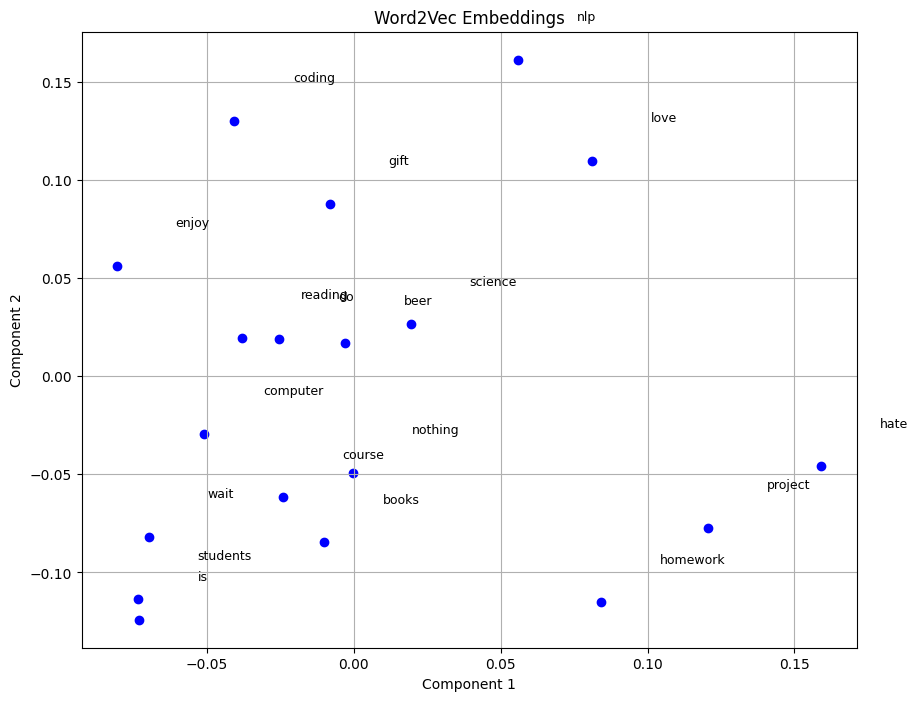

In [9]:
import nltk
nltk.download('averaged_perceptron_tagger')

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(word2vec_model.wv.vectors)

plt.figure(figsize=(10, 8))


def is_noun_or_verb(word):
    pos = nltk.pos_tag([word])[0][1]
    return pos.startswith('N') or pos.startswith('V')

for i, word in enumerate(vocab):
    if not is_noun_or_verb(word):
        continue
    plt.scatter(pca_result[i, 0], pca_result[i, 1], marker='o', color='b')
    plt.text(pca_result[i, 0] + 0.02, pca_result[i, 1] + 0.02, word, fontsize=9)

plt.title('Word2Vec Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

The results may not make much sense with so little data. Feel free to load a larger corpus with NLTK and test out how powerful embeddings can be!